# Mini Weka
**Disciplina: ICC204 – 'Aprendizagem de Máquina e Mineração de Dados'
Prof. Rafael Giusti (rgiusti@icomp.ufam.edu.br)**

**Objetivo**: 
    Implementar o Mini Weka, contendo seus próprios algoritmos para induzir e
empregar os modelos de classificação estudados em aula.

**Formato de entrada**: 

Os indutores e classificadores devem leem arquivos de dados no formato **ARFF**, como abaixo. 
```js
    @RELATION weather

    @ATTRIBUTE outlook {sunny, overcast, rainy}
    @ATTRIBUTE temperature REAL
    @ATTRIBUTE humidity REAL
    @ATTRIBUTE windy {TRUE, FALSE}
    @ATTRIBUTE play {yes, no}

    @DATA
    sunny,85.0,85.0,FALSE,no
    sunny,80.0,90.0,TRUE,no
    overcast,83.0,86.0,FALSE,yes
    rainy,70.0,96.0,FALSE,yes
    rainy,68.0,80.0,FALSE,yes
    rainy,65.0,70.0,TRUE,no
    ...
    %
    %
    %
```

Os classificadores aceitam arquivos que representam os modelos induzidos, isto será feito através do [*Pickles*](https://www.geeksforgeeks.org/saving-a-machine-learning-model/) para salvar e carregar nossos modelos.

## Indutores implementados
Serão ser implementados indutores para as seguintes classes de modelos:
- [Modelo probabilístico Naive Bayes](#modelo-probabilístico-naive-bayes);
- [Árvores de decisão](#árvores-de-decisão);
- [Regras](#regras);
- [Vizinhança](#vizinhaça);
- [Máquinas de vetores de suporte](#máquinas-de-vetores-de-suporte);

## Base de dados
Para testar e validar nossos modelos, usaremos duas bases de dados, a primeira com atributos numéricos e a segunda com atributos nominais. Ambas as bases terão duas versões, uma completa e a segunda com alguns atributos com valores faltando, para que possam ser tratados no preprocessamento e simular melhor dados brutos encontrados no mundo real.
Ambas as bases e outras mais podem ser encontradas no [Weka Data Sets](https://storm.cis.fordham.edu/~gweiss/data-mining/datasets.html)

In [1]:
# Para ler e visualizar os dados usaremos o scipy e pandas
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff

### Iris dataset
Este talvez seja o banco de dados mais conhecido dentro de reconhecimento de padrões. O conjunto de dados contém 3 classes de 50 instâncias cada, onde cada classe se refere a um tipo de planta da íris. Uma classe é linearmente separável das outras duas, estas últimas não são entre si

In [2]:
data, info = loadarff('../data/iris.arff')
data = pd.DataFrame(data)
info

Dataset: iris
	sepallength's type is numeric
	sepalwidth's type is numeric
	petallength's type is numeric
	petalwidth's type is numeric
	class's type is nominal, range is ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica')

In [3]:
data.sample(5)

,sepallength,sepalwidth,petallength,petalwidth,class
122,7.7,2.8,6.7,2.0,b'Iris-virginica'
94,5.6,2.7,4.2,1.3,b'Iris-versicolor'
143,6.8,3.2,5.9,2.3,b'Iris-virginica'
1,4.9,3.0,1.4,0.2,b'Iris-setosa'
125,7.2,3.2,6.0,1.8,b'Iris-virginica'


Na leitura do arquivo ARFF, os valores nominais das espécies acabaram por ser convertido no tipo Byte, para facilitar nosso trabalho vamos converter novamente para o tipo String

In [4]:
data['class'] = data['class'].apply(lambda specie: specie.decode("utf-8"))
data.sample(5)

,sepallength,sepalwidth,petallength,petalwidth,class
77,6.7,3.0,5.0,1.7,Iris-versicolor
67,5.8,2.7,4.1,1.0,Iris-versicolor
58,6.6,2.9,4.6,1.3,Iris-versicolor
132,6.4,2.8,5.6,2.2,Iris-virginica
90,5.5,2.6,4.4,1.2,Iris-versicolor


In [5]:
iris = data

### Weather dataset
Este banco consiste em condições atmosféricas necessárias para se confirmar uma partida de um jogo. O conjunto de dados contém 2 classes com 5 'no's e 9 'yes's, ao que se refere jogar naquelas condições

In [6]:
data, info = loadarff('../data/weather.arff')
data = pd.DataFrame(data)
info

Dataset: weather
	outlook's type is nominal, range is ('sunny', 'overcast', 'rainy')
	temperature's type is numeric
	humidity's type is numeric
	windy's type is nominal, range is ('TRUE', 'FALSE')
	play's type is nominal, range is ('yes', 'no')

In [7]:
data.sample(5)

,outlook,temperature,humidity,windy,play
9,b'rainy',75.0,80.0,b'FALSE',b'yes'
12,b'overcast',81.0,75.0,b'FALSE',b'yes'
13,b'rainy',71.0,91.0,b'TRUE',b'no'
7,b'sunny',72.0,95.0,b'FALSE',b'no'
6,b'overcast',64.0,65.0,b'TRUE',b'yes'


Neste conjunto, todos os valores nominais estão em bytes, faremos a conversão agora

In [8]:
data['outlook'] = data['outlook'].apply(lambda outlook: outlook.decode("utf-8"))
data['windy'] = data['windy'].apply(lambda windy: True if windy.decode("utf-8")=='TRUE' else False)
data['play'] = data['play'].apply(lambda play: play.decode("utf-8"))
data.sample(5)

,outlook,temperature,humidity,windy,play
6,overcast,64.0,65.0,True,yes
7,sunny,72.0,95.0,False,no
0,sunny,85.0,85.0,False,no
3,rainy,70.0,96.0,False,yes
4,rainy,68.0,80.0,False,yes


In [9]:
weather = data

## Visualização dos dados

Antes de iniciar qualquer trabalho em cima dos conjuntos de dados, é importante conhecer bem os mesmos. Usar gráficos e diagramas para visualizar grandes quantidades de dados complexos torna mais fácil compreender como os dados estão distribuídos ou identificar novos padrões. Este conhecimento nos ajuda a tomar decisões de projetos enquanto construímos nosso modelo

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

### Iris plot
Quando não sabemos por onde começar, podemos sempre tentar plotar os atributos em pares, assim obtemos uma visão geral do conjunto

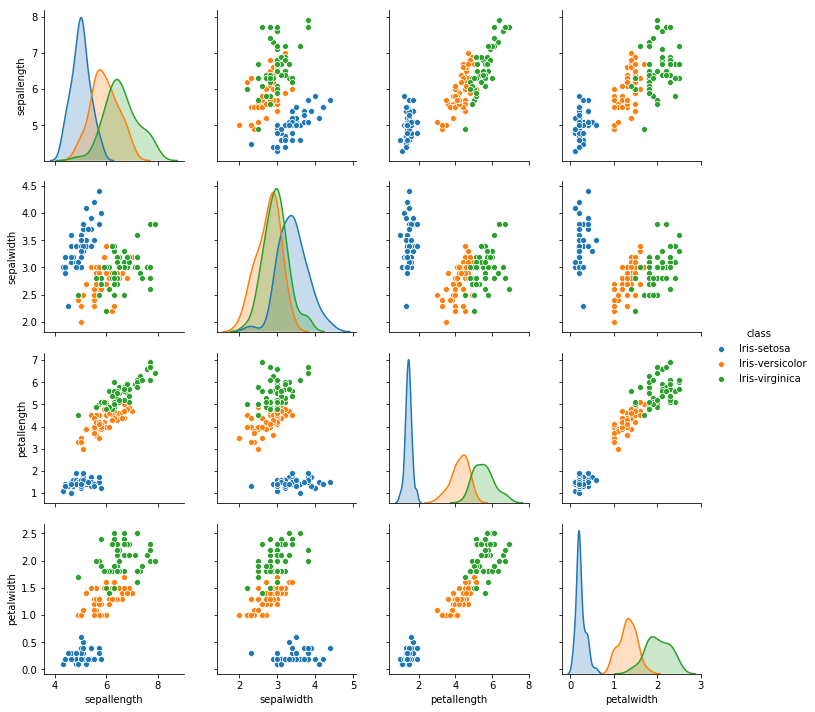

In [11]:
sns.pairplot(iris, hue='class', markers='o')
plt.show()

E analisando o grafico, percebe-se que os atributos 'petallength' e 'petalwidth' representam melhor as amostras ao separar de forma mais precisa as espécies de Iris

### Weather plot
Este conjunto tem apenas dois atributos numéricos então teremos que analisar os demais usando outras ferramentas gráficas

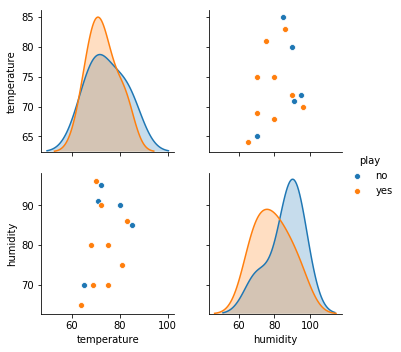

In [12]:
sns.pairplot(weather.drop('windy', axis=1), hue='play', markers='o')
plt.show()

Nota-se pelo plot que os atributos numéricos não separam as amostras de forma satisfatória, sendo assim necessário usar os demais atributos para aprimorar nossa abstração do conhecimento

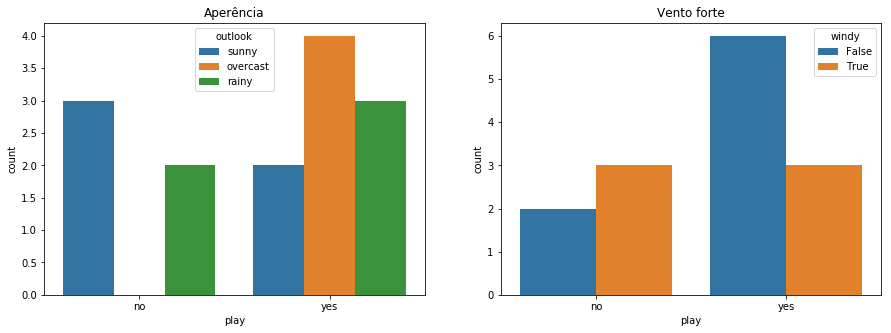

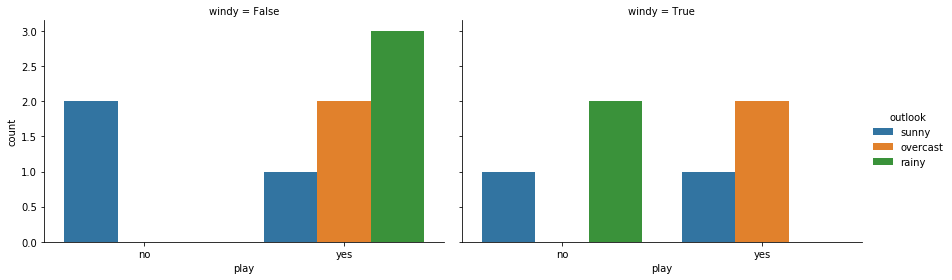

In [43]:
fig = plt.figure(figsize=(15,5))

a = fig.add_subplot(1, 2, 1)
a.set_title('Aperência')
sns.countplot(x="play", hue="outlook", data=weather)

a = fig.add_subplot(1, 2, 2)
a.set_title('Vento forte')
sns.countplot(x="play", hue="windy", data=weather)

plt.show()

sns.catplot(x="play", hue="outlook", col="windy", data=weather, kind="count", height=4, aspect=1.5)
plt.show()

Apesar da visualisação simples apresentada acima, é o suficiente para observar de forma tímida como e quanto os atributos infuenciam a classe alvo

##  Modelo probabilístico Naive Bayes<a name="modelo-probabilístico-naive-bayes"></a>

O Naive Bayes é um classificador probabilístico simples baseado no teorema de Bayes. O teorema de Bayes descreve a probabilidade de um evento, com base no conhecimento prévio de condições que podem estar relacionadas ao evento. Por exemplo, se o alzheimer está relacionado à idade, então, usando o teorema de Bayes, a idade de uma pessoa pode ser usada para avaliar com mais precisão a probabilidade de alzheimer, comparada com a avaliação da probabilidade sem conhecimento da idade da pessoa.

O teorema de Bayes é declarado matematicamente como a seguinte equação:

$$
    P(A\mid B) = \frac{P(B\mid A)P(A)}{P(B)}
$$

onde $A$ e $B$ são eventos e $P(B)\neq 0$.
- $P(A\mid B)$  é uma probabilidade condicional: a probabilidade do evento $A$ ocorrer dado que $B$ é verdadeiro.
- $P(B\mid A)$ também é uma probabilidade condicional: a probabilidade de evento $B$ ocorrer dado que $A$ é verdadeiro.
- $P(A)$ e $P(B)$ são as probabilidades de observar $A$ e $B$ independentemente uns dos outros; isso é conhecido como a probabilidade marginal.

Este indutor é chamado de ingênuo pois assume que todos os atributos são independentes entre si:

$$
    f_{nb}(X) = argmax_{c_{j} \in \Omega} = \begin{Bmatrix} p(c_{j})\prod_{i=1}^{M}p(x_{i}\mid c_{j})\end{Bmatrix}
$$

Os parâmetros do modelo são simplesmente as probabilidades posteriores $p(x_{i}\mid c_{j})$ e as
probabilidades a priori $p(c_{j})$:
- Treinamento: calcular e armazenar os valores de probabilidades
- Classificação de um novo exemplo: calcular as probabilidades para os atributos e classes relevante e escolher o argumento (classe) que maximiza a probabilidade posterior

In [20]:
from sklearn.preprocessing import LabelEncoder
import math

class NaiveBayes(object):
    
    def __init__(self):
        self.n_feature = None
    
    def calculate_probability(self, x, mean, stdev):
        return (1 / (math.sqrt(2*math.pi) * stdev)) * math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    
    def calculate_class_probabilities(self, sample):
        probabilities = {}
        for class_value, class_summaries in self.summaries.items():
            probabilities[class_value] = 1
            for i in range(self.n_feature):
                mean, stdev = class_summaries[i]
                x = sample[i]
                probabilities[class_value] *= self.calculate_probability(x, mean, stdev)
        return probabilities
    
    def separate_by_class(self, X, y):
        return { c : X[y==c] for c in np.unique(y) }
    
    def summarize(self, instances):
        return [ (np.mean(instances[:,i]), np.std(instances[:,i])) for i in range(self.n_feature)]
        
    def check_X_y(self, X, y=None, reset=False):
        n_samples, n_feature = X.shape
        
        if(y is not None and n_samples != len(y)):  raise Exception('Numero diferente de dados e rótulos das amotras')
        if(reset):
            self.n_feature = n_feature
            self.feature_label_encoder = [None for i in range(n_feature)]
        if(self.n_feature is None): raise Exception('Tente treinar o modelo primeiro')
        elif(self.n_feature != n_feature): raise Exception(f'Número de atributos difere do cedido anteriomente: {n_feature} ao invés de {self.n_feature}')
        
        feature_label_encoder = self.feature_label_encoder
        for i in range(n_feature):
            try:
                float(X[0,i])
            except:
                if(feature_label_encoder[i]==None):
                    feature_label_encoder[i] = LabelEncoder()
                    feature_label_encoder[i].fit(X[:, i])
                X[:, i] = feature_label_encoder[i].transform(X[:,i])
                
        self.n_samples = n_samples
        self.n_feature = n_feature
        self.feature_label_encoder = feature_label_encoder
                
        return X,y
            
    def fit(self, X, y):
        
        X,y = self.check_X_y(X,y, reset=True)
        separated = self.separate_by_class(X, y)
        
        summaries = {}
        for classValue, instances in separated.items():
            summaries[classValue] = self.summarize(instances)
            
        self.summaries = summaries
    
    def _predict(self, sample):
        probabilities = self.calculate_class_probabilities(sample)
        best_label, best_prob = None, -1
        for class_value, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_prob = probability
                best_label = class_value
        return best_label
    
    def predict(self, X):
        X,_ = self.check_X_y(X)
        return [ self._predict(sample) for sample in X]